## Palantir pseudotime workflow

- last updated: 5/30/2024
- author: Yang-Joon Kim

Here, we will test out the example notebook from Palantir (Setty and Pe'er, 2019) to compute the pseudotime from single-cell Multiome (RNA).

- Source: https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb

## NOTES from 5/11/2024

- After some exploration using Palantir, it's tricky to apply for datasets with unclear trajectories, or trajectories which were hard to resolve with DPT, as both DPT and Palantir rely on Diffusion Map (in the backend).

- For example, the TDR124reseq dataset (30 somites)

## Introduction - Setty et al.
Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination.

In [1]:
import palantir
import scanpy as sc
import pandas as pd
import os
import numpy as np

from scipy.sparse import issparse

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [2]:
# load the data (adata)
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_RNA_master_filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

### NOTES:

- ~~log-normalized the data (using pseudocount of 0.1, instead of 1)~~
- ~~re-compute the PCs~~
- import the PCs computed from "integration" by Seurat using rPCA.

In [17]:
# # re-do the log-normalization
# sc.pp.normalize_total(adata, target_sum=1e4)
# palantir.preprocess.log_transform(adata)

In [25]:
# # compute the HVG (note that "seurat_v3" flavor requires "raw counts")
# sc.pp.highly_variable_genes(adata, layer="counts", flavor="seurat_v3", n_top_genes=3000, 
#                             min_mean=0.0125, max_mean=3, min_disp=0.5)

In [27]:
# adata.var[adata.var.highly_variable==True]

,features,highly_variable,highly_variable_rank,means,variances,variances_norm
ripply2,ripply2,True,2724.0,0.007564,0.009627,1.130740
chrm2a,chrm2a,True,137.0,0.011649,0.046921,2.610519
cmah,cmah,True,1019.0,0.000605,0.000907,1.462493
glipr1a,glipr1a,True,2926.0,0.004085,0.004977,1.113405
nap1l1,nap1l1,True,2385.0,0.634947,1.157532,1.166145
...,...,...,...,...,...,...
mt-co1,mt-co1,True,2706.0,17.213616,185.511632,1.130870
mt-co2,mt-co2,True,2044.0,31.379879,611.474523,1.205650
mt-atp6,mt-atp6,True,1374.0,14.878215,170.561501,1.355129
mt-co3,mt-co3,True,1987.0,27.235401,470.200895,1.216546


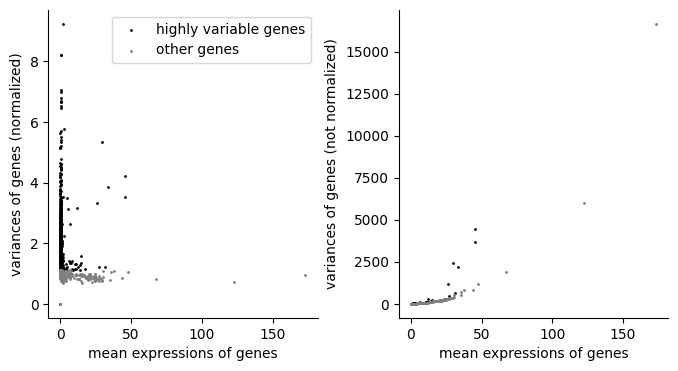

In [28]:
# sc.pl.highly_variable_genes(adata)

In [29]:
# # save the adata in the .raw slot (log-normalized counts)
# adata.raw = adata

In [30]:
# # scale the data
# sc.pp.scale(adata, max_value=10)

In [31]:
# # computing PCs
# sc.tl.pca(adata, svd_solver="arpack")

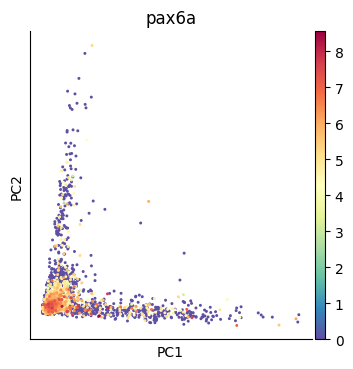

In [34]:
# sc.pl.pca(adata, color="pax6a")

In [4]:
# import the integrated_pca (datasets across different timepoints were integrated using rPCA in Seurat)
integrated_pca = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_pca.csv", index_col=0)
integrated_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
AAACAGCCACCTAAGC-1_1,2.337219,-1.429061,-5.863204,2.233877,7.256290,2.174646,2.644288,-0.268576,1.116962,-1.540614,...,-2.423818,0.746383,2.348913,0.599667,0.268230,0.037639,1.093597,2.292499,-2.180902,-0.609504
AAACAGCCAGGGAGGA-1_1,5.925528,-4.112149,-3.745973,-2.587663,-0.824526,-0.770181,-0.629575,-2.431229,-0.577661,-2.289982,...,-0.596900,-0.580806,-0.151273,-2.579358,0.484555,4.244384,1.265782,1.041933,-0.790714,1.459041
AAACAGCCATAGACCC-1_1,3.573711,6.779139,-1.335192,-7.599583,3.383914,-2.221623,-0.410902,2.574602,2.494892,1.434072,...,-1.369190,-1.072793,0.729661,-2.383013,-2.462715,0.829521,-1.447832,-1.037105,-0.019790,-0.119438
AAACATGCAAACTCAT-1_1,-2.198315,-2.919139,4.460779,-3.449388,0.942443,2.305146,-0.609150,-0.384336,3.204518,-2.120470,...,-2.744978,0.271759,0.368134,0.654299,0.698463,3.075106,-1.206539,-0.504473,-1.483571,0.275104
AAACATGCAAGGACCA-1_1,-6.611312,4.038513,-0.699466,2.057417,-0.530705,-0.074898,0.746187,-0.692077,-0.832365,0.885615,...,-0.152070,0.280815,0.164693,0.946766,-0.844613,0.023811,0.588854,0.407269,0.394212,0.313771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCCTCAGT-1_7,0.441136,4.210098,-1.878576,-7.065087,2.285191,-0.018840,-0.017662,1.791621,-0.079471,0.505175,...,-1.099142,0.409754,-1.444433,0.163811,-0.333010,1.128468,-0.088681,0.777200,0.695411,-0.442525
TTTGTTGGTACCTTAC-1_7,8.450310,-4.444844,-3.560358,1.049780,-11.561294,1.416145,2.944198,5.288898,-7.119284,0.224083,...,2.083931,-0.448638,-0.363396,1.299509,2.904005,-0.070208,-0.433305,-2.984334,0.827288,0.377326
TTTGTTGGTATTGAGT-1_7,-4.002701,-0.805743,3.497905,0.699492,-0.366578,0.712642,0.655097,-0.752034,0.187395,-2.081523,...,0.383833,0.009061,-0.016094,-0.579264,-0.809333,1.313239,-0.065441,-1.210706,-0.035018,1.377053
TTTGTTGGTGCGCGTA-1_7,-2.591925,2.249332,-3.339347,2.140311,-1.152693,-0.275836,-1.398287,2.606338,0.233157,-1.435872,...,-1.807821,-0.664764,0.581497,-0.440832,1.136641,-0.377381,1.800268,-0.233631,-1.426484,1.090966


In [6]:
# filter out the low-quality cells
integrated_pca = integrated_pca[integrated_pca.index.isin(adata.obs_names)]
integrated_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
AAACAGCCACCTAAGC-1_1,2.337219,-1.429061,-5.863204,2.233877,7.256290,2.174646,2.644288,-0.268576,1.116962,-1.540614,...,-2.423818,0.746383,2.348913,0.599667,0.268230,0.037639,1.093597,2.292499,-2.180902,-0.609504
AAACAGCCAGGGAGGA-1_1,5.925528,-4.112149,-3.745973,-2.587663,-0.824526,-0.770181,-0.629575,-2.431229,-0.577661,-2.289982,...,-0.596900,-0.580806,-0.151273,-2.579358,0.484555,4.244384,1.265782,1.041933,-0.790714,1.459041
AAACAGCCATAGACCC-1_1,3.573711,6.779139,-1.335192,-7.599583,3.383914,-2.221623,-0.410902,2.574602,2.494892,1.434072,...,-1.369190,-1.072793,0.729661,-2.383013,-2.462715,0.829521,-1.447832,-1.037105,-0.019790,-0.119438
AAACATGCAAACTCAT-1_1,-2.198315,-2.919139,4.460779,-3.449388,0.942443,2.305146,-0.609150,-0.384336,3.204518,-2.120470,...,-2.744978,0.271759,0.368134,0.654299,0.698463,3.075106,-1.206539,-0.504473,-1.483571,0.275104
AAACATGCAAGGACCA-1_1,-6.611312,4.038513,-0.699466,2.057417,-0.530705,-0.074898,0.746187,-0.692077,-0.832365,0.885615,...,-0.152070,0.280815,0.164693,0.946766,-0.844613,0.023811,0.588854,0.407269,0.394212,0.313771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCCTCAGT-1_7,0.441136,4.210098,-1.878576,-7.065087,2.285191,-0.018840,-0.017662,1.791621,-0.079471,0.505175,...,-1.099142,0.409754,-1.444433,0.163811,-0.333010,1.128468,-0.088681,0.777200,0.695411,-0.442525
TTTGTTGGTACCTTAC-1_7,8.450310,-4.444844,-3.560358,1.049780,-11.561294,1.416145,2.944198,5.288898,-7.119284,0.224083,...,2.083931,-0.448638,-0.363396,1.299509,2.904005,-0.070208,-0.433305,-2.984334,0.827288,0.377326
TTTGTTGGTATTGAGT-1_7,-4.002701,-0.805743,3.497905,0.699492,-0.366578,0.712642,0.655097,-0.752034,0.187395,-2.081523,...,0.383833,0.009061,-0.016094,-0.579264,-0.809333,1.313239,-0.065441,-1.210706,-0.035018,1.377053
TTTGTTGGTGCGCGTA-1_7,-2.591925,2.249332,-3.339347,2.140311,-1.152693,-0.275836,-1.398287,2.606338,0.233157,-1.435872,...,-1.807821,-0.664764,0.581497,-0.440832,1.136641,-0.377381,1.800268,-0.233631,-1.426484,1.090966


In [8]:
adata.obsm["X_integrated_pca"] = integrated_pca.to_numpy()
adata

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap', 'X_integrated_pca'
    layers: 'counts'

In [5]:
# adata.obsm["X_pca"] = integrated_pca.to_numpy()
# adata

AnnData object with n_obs × n_vars = 95196 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'nCount_peaks_integrated', 'nFe

## compute the Diffusion maps

- Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [15]:
# sc.pp.neighbors(adata, n_pcs=30, use_rep="X_integrated_pca")

In [9]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=10, pca_key="X_integrated_pca")

In [10]:
adata

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors', 'DM_EigenValues'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap', 'X_integrated_pca', 'DM_EigenVec

In [11]:
ms_data = palantir.utils.determine_multiscale_space(adata, n_eigs=None)

### MAGIC imputation

MAGIC is an imputation technique developed in the Pe'er lab for single cell data imputation. Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.

In [12]:
imputed_X = palantir.utils.run_magic_imputation(adata)

In [13]:
adata

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors', 'DM_EigenValues'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap', 'X_integrated_pca', 'DM_EigenVec

In [ ]:
palantir.plot.plot_diffusion_components(adata)
plt.show()

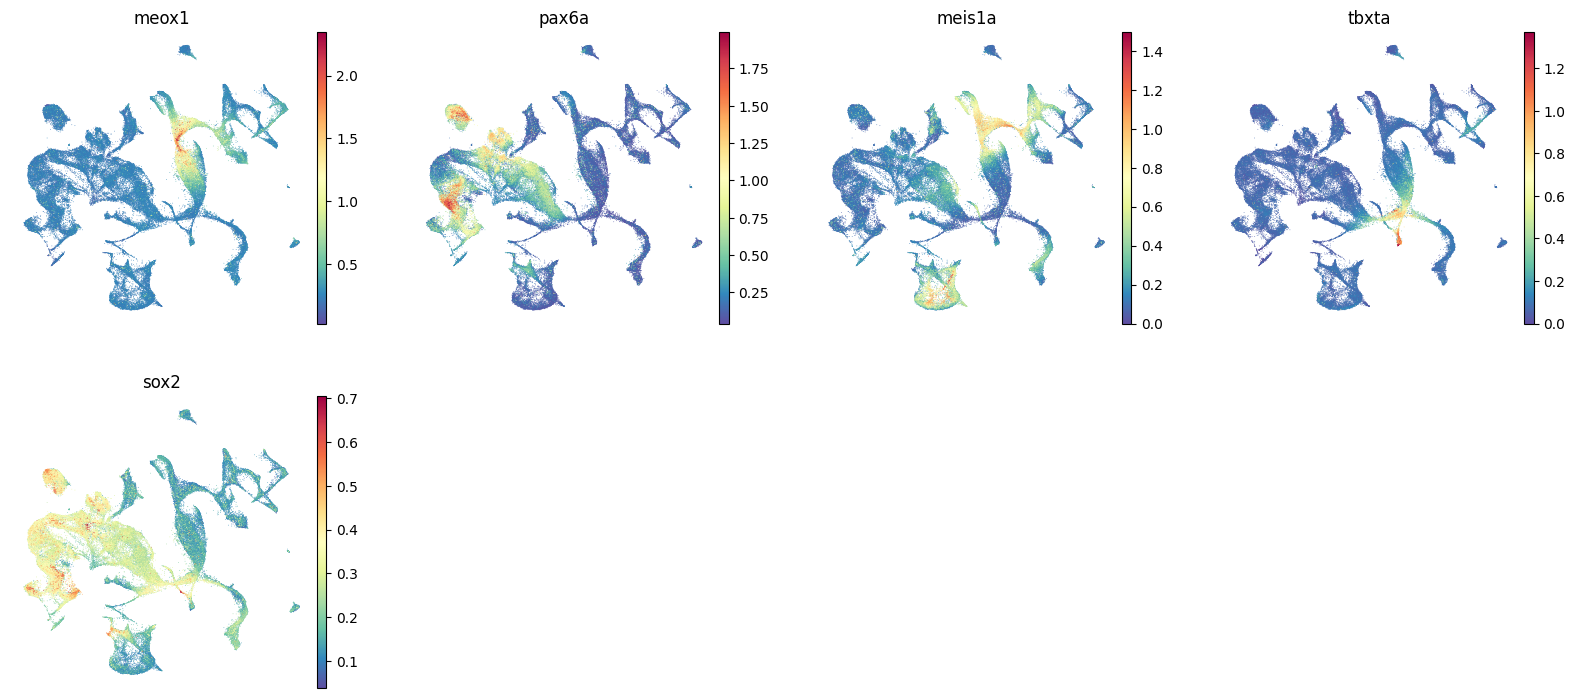

In [15]:
sc.pl.embedding(
    adata,
    basis="X_wnn.umap",
    layer="MAGIC_imputed_data",
    color=["meox1", "pax6a", "meis1a", "tbxta","sox2"],
    frameon=False,
)
plt.show()

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1107: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


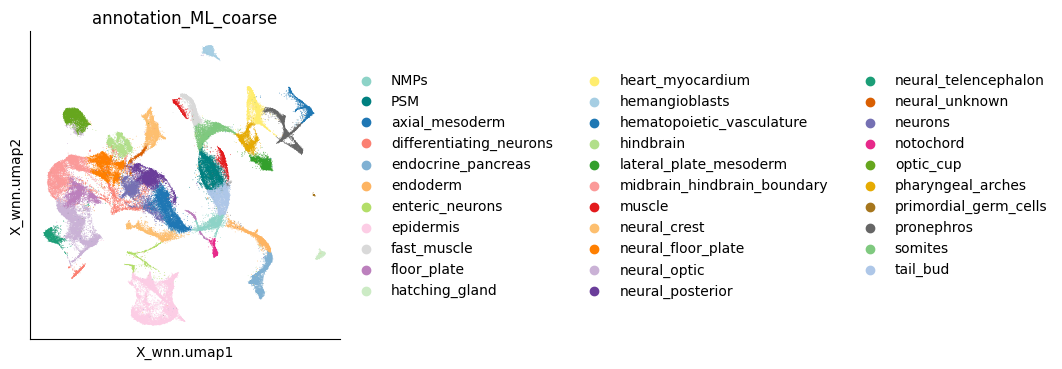

In [17]:
sc.pl.embedding(adata, basis = "X_wnn.umap", color="annotation_ML_coarse")

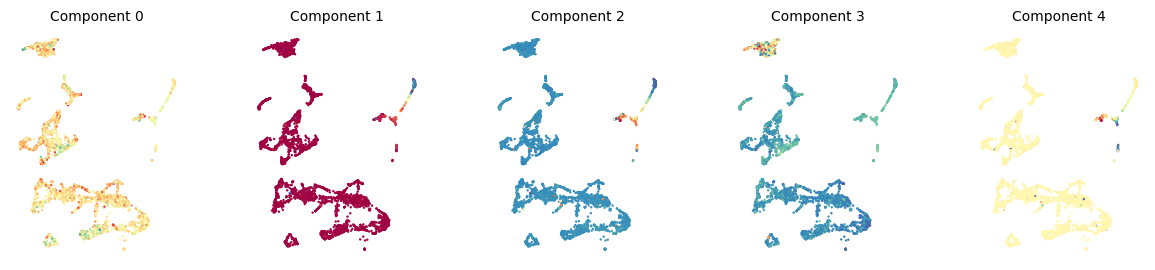

In [174]:
# Diffusion maps visualization
palantir.plot.plot_diffusion_components(nmps, embedding_basis="X_umap_aligned")
plt.show()

### 2.1.2. Define llineage

We will make lineage annotation on the scRNA-seq data.
For example, the demo scRNA-seq data include roughly two lineages: megakaryocytes-erythroid (ME) lineage and granulocytes-monocyte (GM) lineage.

To get better pseudotime information, calculate the pseudotime for each cell lineage individually.
Then, all pseudotime information of each lineage are merged into one.

Lineages can be specified using lists.  The lineage structure and number of branches will vary depending on the dataset. Please adjust the code as necessary to match your data. 

In [175]:
# Here, clusters can be classified into either MEP lineage or GMP lineage

clusters_in_meso_lineage = ["NMPs", "PSM", "Somites","Muscle"]
clusters_in_neuroecto_lineage = ["NMPs", "Neural_Posterior", "Neural_Anterior"]

# Make a dictionary
lineage_dictionary = {"Lineage_Meso": clusters_in_meso_lineage,
           "Lineage_NeuroEcto": clusters_in_neuroecto_lineage}

# # Input lineage information into pseudotime object
# pt.set_lineage(lineage_dictionary=lineage_dictionary)

# # Visualize lineage information
# pt.plot_lineages()

## 2.2. Add the initial and terminal states

The DPT pseudotime calculation requires the user to specify a root cell.
We will manually estimate the root cell for each lineage.

Please read documentation (https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt) to find detailed information about the DPT algorithm and root cells

In [19]:
# extract the centroid cell, and define it as the "root cell" (this logic can be revisited with better workflow)

# subset the NMP population
adata_nmps = adata[adata.obs.annotation_ML_coarse=="NMPs"]

# extract the NMP UMAP coordinates
nmp_coords = pd.DataFrame(adata_nmps.obsm["X_wnn.umap"], columns=["UMAP_1","UMAP_2"], index=adata_nmps.obs_names)

# calculate the centroid of the NMP population
centroid = nmp_coords[['UMAP_1', 'UMAP_2']].mean().values
centroid

# Find the closest cell to the centroid
nmp_coords['distance_to_centroid'] = np.sqrt((nmp_coords['UMAP_1'] - centroid[0]) ** 2 + (nmp_coords['UMAP_2'] - centroid[1]) ** 2)
closest_cell_index = nmp_coords['distance_to_centroid'].idxmin()

# Now you have the index of the closest cell to the centroid
root_cell_id = closest_cell_index
print(f"The root cell index for the NMP population is: {root_cell_id}")

The root cell index for the NMP population is: GCATGAGCATGCTCCC-1_2


In [55]:
# find the cell_ids (indices) for the terminal states () - we know that they are either the top left or top right cells
terminal_celltype = "hematopoietic_vasculature"

# Subset the celltype population
adata_sub = adata[adata.obs['annotation_ML_coarse'] == terminal_celltype]

# Extract the UMAP coordinates for the "celltype" cluster
celltype_coords = pd.DataFrame(adata_sub.obsm['X_wnn.umap'], columns=["UMAP_1", "UMAP_2"], index=adata_sub.obs_names)

# Find the highest UMAP_2 value to identify the top-most cell
# top_most_cell_index = celltype_coords['UMAP_2'].idxmax()
top_most_cell_index = (celltype_coords['UMAP_1'] + celltype_coords['UMAP_2']).idxmax()

# Now you have the index of the top-most cell in the "celltype" cluster
top_neural_cell_id = top_most_cell_index
print(f"The top-most cell index for the {terminal_celltype} population is: {top_neural_cell_id}")


The top-most cell index for the hematopoietic_vasculature population is: TCGGTTCTCCTCATCA-1_4


In [35]:
# find the cell_ids (indices) for the terminal states ()
terminal_celltype = "neural_telencephalon"

# Subset the celltype population
adata_sub = adata[adata.obs['annotation_ML_coarse'] == terminal_celltype]

# Extract the UMAP coordinates for the "celltype" cluster
celltype_coords = pd.DataFrame(adata_sub.obsm['X_wnn.umap'], columns=["UMAP_1", "UMAP_2"], index=adata_sub.obs_names)

# Find the highest UMAP_1 value to identify the left-most cell
top_most_cell_index = celltype_coords['UMAP_1'].idxmin()

# Now you have the index of the top-most cell in the "celltype" cluster
top_neural_cell_id = top_most_cell_index
print(f"The top-most cell index for the {terminal_celltype} population is: {top_neural_cell_id}")

The top-most cell index for the neural_telencephalon population is: CAAGTGAAGCTATTGA-1_1


In [45]:
# find the cell_ids (indices) for the terminal states () - we know that they are either the top left or top right cells
terminal_celltype = "endocrine_pancreas"

# Subset the celltype population
adata_sub = adata[adata.obs['annotation_ML_coarse'] == terminal_celltype]

# Extract the UMAP coordinates for the "celltype" cluster
celltype_coords = pd.DataFrame(adata_sub.obsm['X_wnn.umap'], columns=["UMAP_1", "UMAP_2"], index=adata_sub.obs_names)

# Find the highest UMAP_2 value to identify the top-most cell
top_most_cell_index = (celltype_coords['UMAP_1'] - celltype_coords['UMAP_2']).idxmax()

# Now you have the index of the top-most cell in the "celltype" cluster
top_neural_cell_id = top_most_cell_index
print(f"The top-most cell index for the {terminal_celltype} population is: {top_neural_cell_id}")

The top-most cell index for the endocrine_pancreas population is: TTTCAGTTCGGGATTT-1_4


In [37]:
# find the cell_ids (indices) for the terminal states () - we know that they are either the top left or top right cells
terminal_celltype = "epidermis"

# Subset the celltype population
adata_sub = adata[adata.obs['annotation_ML_coarse'] == terminal_celltype]

# Extract the UMAP coordinates for the "celltype" cluster
celltype_coords = pd.DataFrame(adata_sub.obsm['X_wnn.umap'], columns=["UMAP_1", "UMAP_2"], index=adata_sub.obs_names)

# Find the highest UMAP_2 value to identify the top-most cell
top_most_cell_index = celltype_coords['UMAP_2'].idxmin()

# Now you have the index of the top-most cell in the "celltype" cluster
top_neural_cell_id = top_most_cell_index
print(f"The top-most cell index for the {terminal_celltype} population is: {top_neural_cell_id}")

The top-most cell index for the epidermis population is: GCGCCTTGTCCGCTGT-1_6


In [56]:
terminal_states = pd.Series(
    ["hematopoietic_vasculature", "neural_telencephalon", "endocrine_pancreas", "epidermis"],
    index=["TCGGTTCTCCTCATCA-1_4", "CAAGTGAAGCTATTGA-1_1", "TTTCAGTTCGGGATTT-1_4", "GCGCCTTGTCCGCTGT-1_6"],
)
terminal_states

TCGGTTCTCCTCATCA-1_4    hematopoietic_vasculature
CAAGTGAAGCTATTGA-1_1         neural_telencephalon
TTTCAGTTCGGGATTT-1_4           endocrine_pancreas
GCGCCTTGTCCGCTGT-1_6                    epidermis
dtype: object

In [39]:
help(palantir.plot.highlight_cells_on_umap)

Help on function highlight_cells_on_umap in module palantir.plot:

highlight_cells_on_umap(data: Union[anndata._core.anndata.AnnData, pandas.core.frame.DataFrame], cells: Union[List[str], Dict[str, str], pandas.core.series.Series, pandas.core.indexes.base.Index, numpy.ndarray, str], annotation_offset: float = 0.03, s: float = 1, s_highlighted: float = 10, fig: Union[matplotlib.figure.Figure, NoneType] = None, ax: Union[matplotlib.axes._axes.Axes, NoneType] = None, embedding_basis: str = 'X_umap') -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
     Highlights and annotates specific cells on a UMAP plot.
    
     Parameters
     ----------
     data : Union[sc.AnnData, pd.DataFrame]
         Either a Scanpy AnnData object or a DataFrame of UMAP coordinates.
     cells : Union[List[str], Dict[str, str], pd.Series, pd.Index, np.ndarray, str]
         Cells to highlight on the UMAP. Can be provided as:
             - a list, dict, or pd.Series: used as cell names (values in

In [29]:
initial_state = pd.Series(
    ["initial_state"],
    index=["GCATGAGCATGCTCCC-1_2"],
)
initial_state
# initial_state = {"initial_nmp":"GGGAGTAGTAGGTTGC-1"}

GCATGAGCATGCTCCC-1_2    initial_state
dtype: object

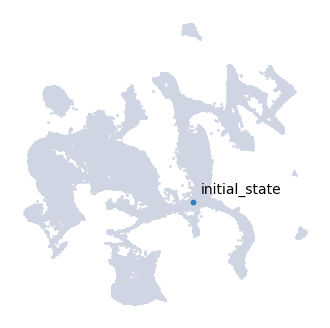

In [57]:
palantir.plot.highlight_cells_on_umap(adata, initial_state, embedding_basis="X_wnn.umap")
plt.show()

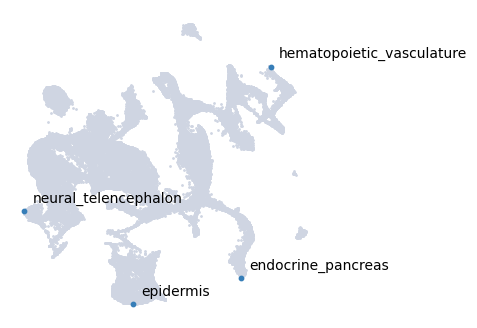

In [58]:
palantir.plot.highlight_cells_on_umap(adata, terminal_states, embedding_basis="X_wnn.umap")
plt.show()

In [59]:
# pick the root cell
start_cell = "GCATGAGCATGCTCCC-1_2"

# run Palantir
pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states,
    knn=200
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.16758240858713785 minutes
Determining pseudotime...
Shortest path distances using 200-nearest neighbor graph...
Time for shortest paths: 5.550877277056376 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


### visualize the Palantir results

/home/yang-joon.kim/.conda/envs/seacells/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1107: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


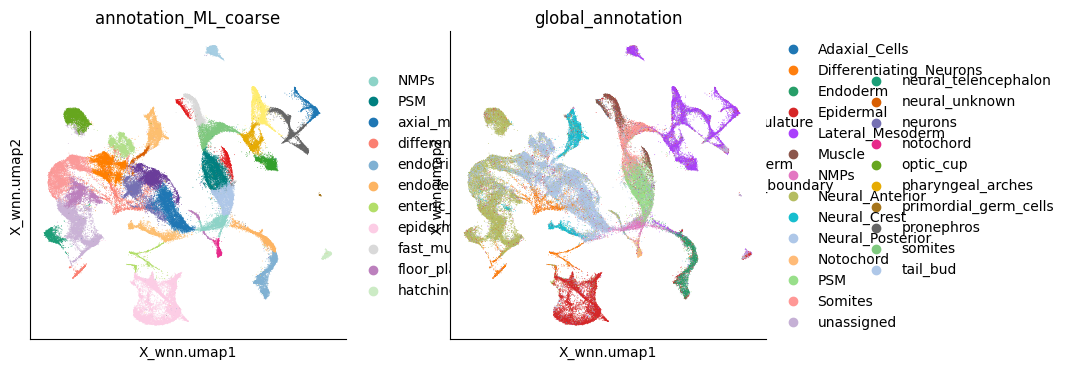

In [53]:
sc.pl.embedding(adata, basis="X_wnn.umap", color=["annotation_ML_coarse", "global_annotation"])

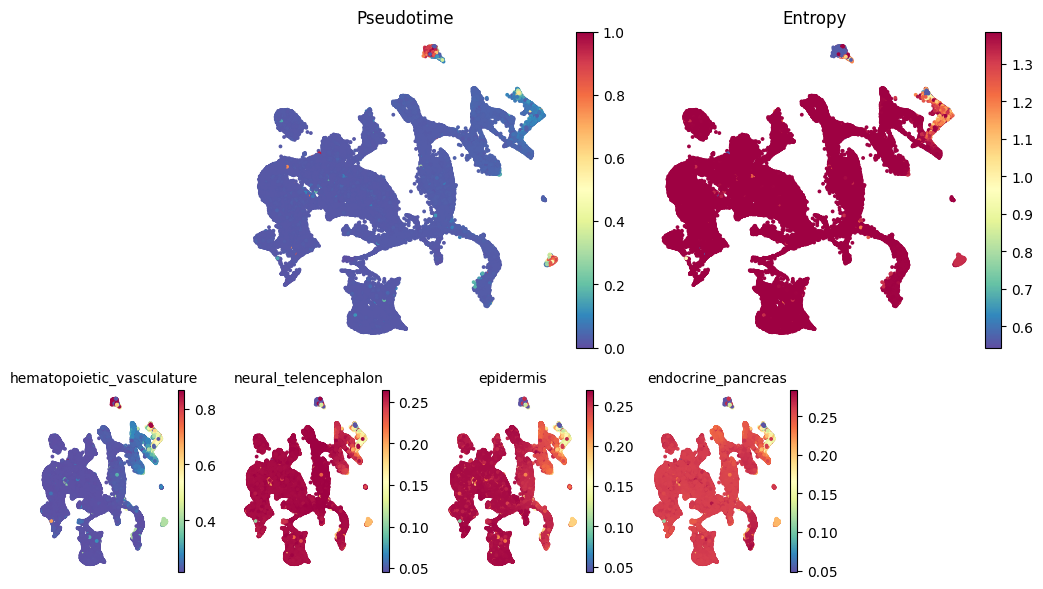

In [54]:
palantir.plot.plot_palantir_results(adata, embedding_basis="X_wnn.umap", s=3)
plt.show()

In [60]:
adata

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'palantir_pseudotime', 'palantir_entropy'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors', 'DM_EigenValues', 'palantir_waypoints'
    obsm: 'X_umap.at

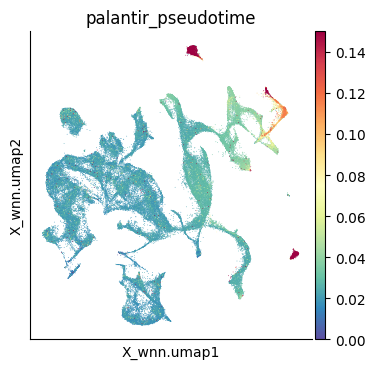

In [68]:
sc.pl.embedding(adata, basis="X_wnn.umap", color="palantir_pseudotime", vmax=0.15)

### Gene expression trends

Gene expression trends over pseudotime provide insights into the dynamic behavior of genes during cellular development or progression. By examining these trends, we can uncover the timing of gene expression changes and identify pivotal regulators of cellular states. Palantir provides tools for computing these gene expression trends.

Here, we'll outline the steps to compute gene trends over pseudotime using Palantir.

Selecting cells of a specific trend

Before computing the gene expression trends, we first need to select cells associated with a specific branch of the pseudotime trajectory. We accomplish this by using the select_branch_cells function. The parameter q is used to control the selection's stringency.

In [69]:
masks = palantir.presults.select_branch_cells(adata, eps=0)


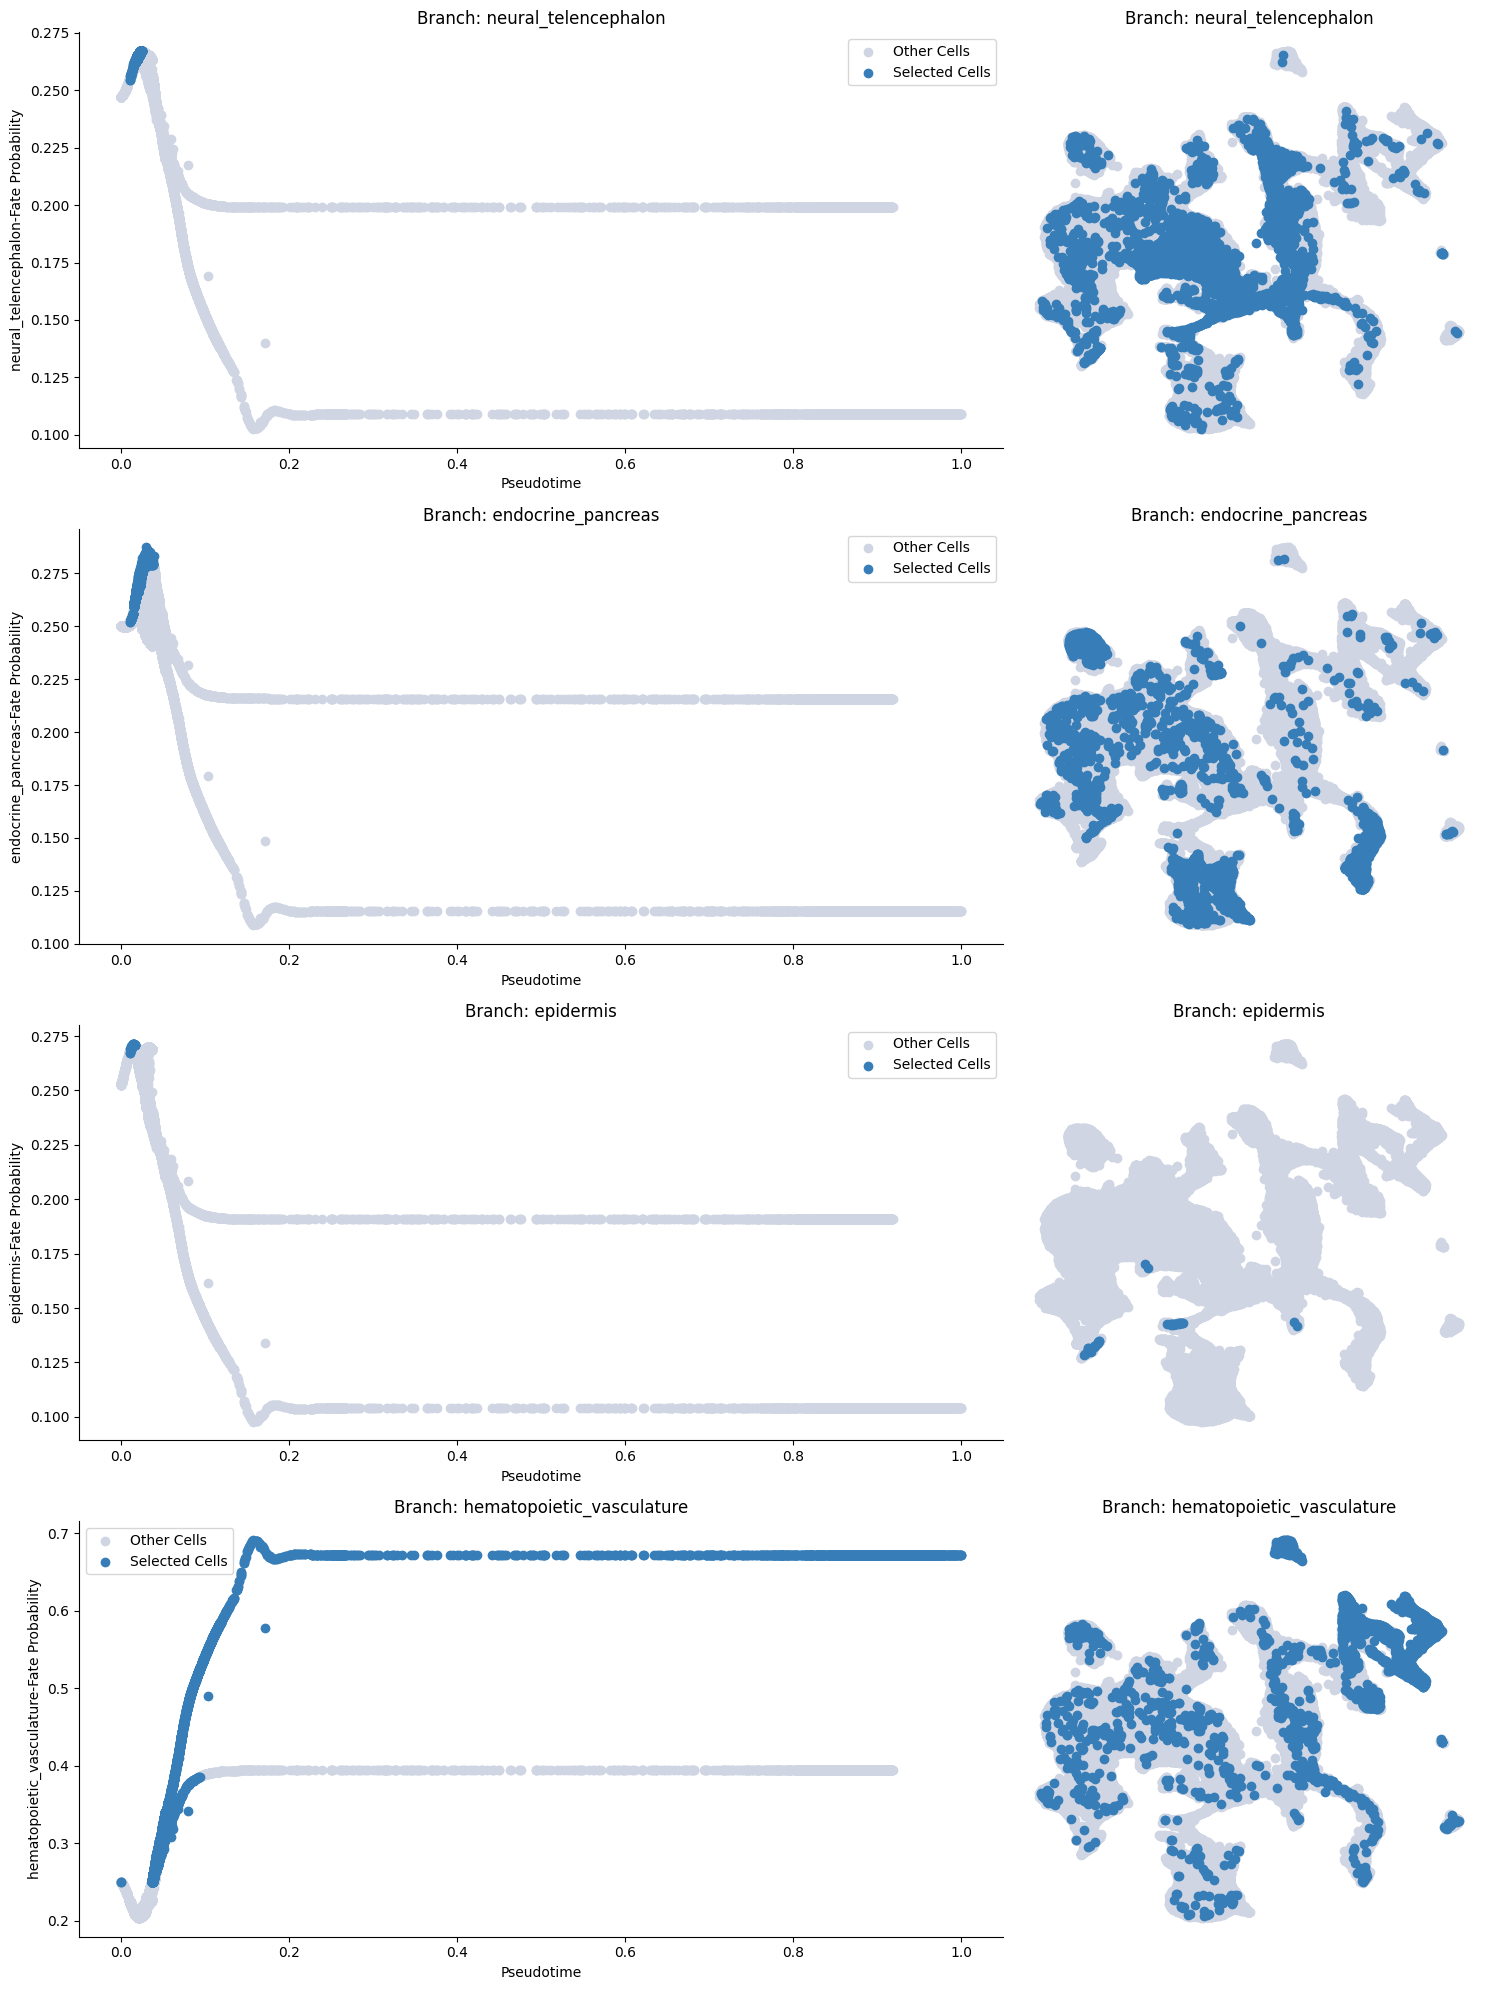

In [70]:
palantir.plot.plot_branch_selection(adata, embedding_basis="X_wnn.umap")
plt.show()

[2024-05-31 10:11:19,401] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (7,895) and rank = 1.0.
[2024-05-31 10:11:19,402] [INFO    ] Using covariance function Matern52(ls=1.8463644383077462).
[2024-05-31 10:11:20,048] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: hematopoietic_vasculature'}>

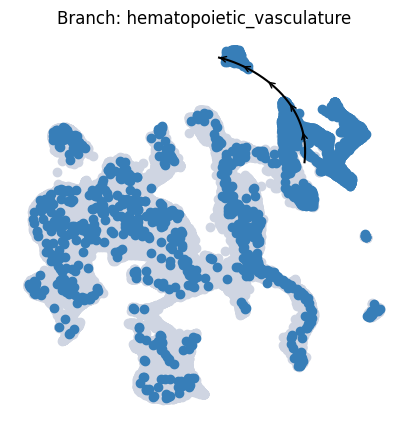

In [71]:
palantir.plot.plot_trajectory(adata, "hematopoietic_vasculature", embedding_basis="X_wnn.umap")

[2024-05-31 10:11:30,799] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (50) >= n_samples (43) and rank = 1.0.
[2024-05-31 10:11:30,800] [INFO    ] Using covariance function Matern52(ls=1.8463644383077462).
[2024-05-31 10:11:30,819] [INFO    ] Recomputing covariance decomposition for predictive function.


<Axes: title={'center': 'Branch: epidermis'}>

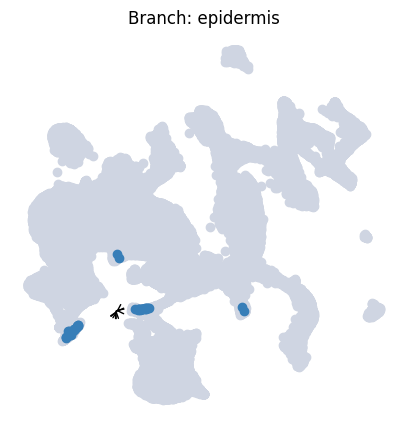

In [72]:
palantir.plot.plot_trajectory(adata, "epidermis", embedding_basis="X_wnn.umap")

[2024-05-31 10:12:13,559] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (7,895) and rank = 1.0.
[2024-05-31 10:12:13,559] [INFO    ] Using covariance function Matern52(ls=1.8463644383077462).
[2024-05-31 10:12:13,560] [INFO    ] Computing 50 landmarks with k-means clustering.


<Axes: title={'center': 'Branch: hematopoietic_vasculature'}, xlabel='wnn.umap1', ylabel='wnn.umap2'>

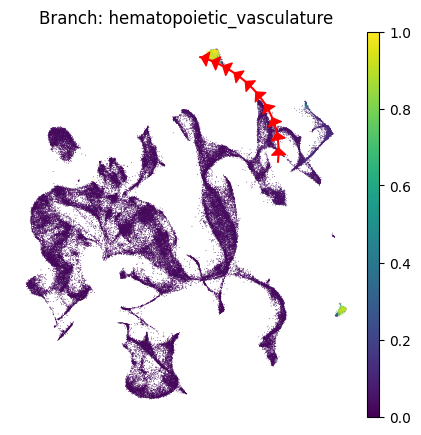

In [73]:
palantir.plot.plot_trajectory(
    adata,
    "hematopoietic_vasculature",
    cell_color="palantir_pseudotime",
    n_arrows=10,
    color="red",
    embedding_basis="X_wnn.umap",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)

In [74]:
gene_trends = palantir.presults.compute_gene_trends(
    adata,
    expression_key="MAGIC_imputed_data",
)

neural_telencephalon
[2024-05-31 10:12:22,303] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (7,969) and rank = 1.0.
[2024-05-31 10:12:22,304] [INFO    ] Using covariance function Matern52(ls=1.0).
epidermis
[2024-05-31 10:12:24,438] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (43) and rank = 1.0.
[2024-05-31 10:12:24,439] [INFO    ] Using covariance function Matern52(ls=1.0).
hematopoietic_vasculature
[2024-05-31 10:12:25,236] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (7,895) and rank = 1.0.
[2024-05-31 10:12:25,237] [INFO    ] Using covariance function Matern52(ls=1.0).
endocrine_pancreas
[2024-05-31 10:12:26,831] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (6,919) and rank = 1.0.
[2024-05-31 10:12:26,832] [INFO    ] Using covariance function Matern52(ls=1.0).


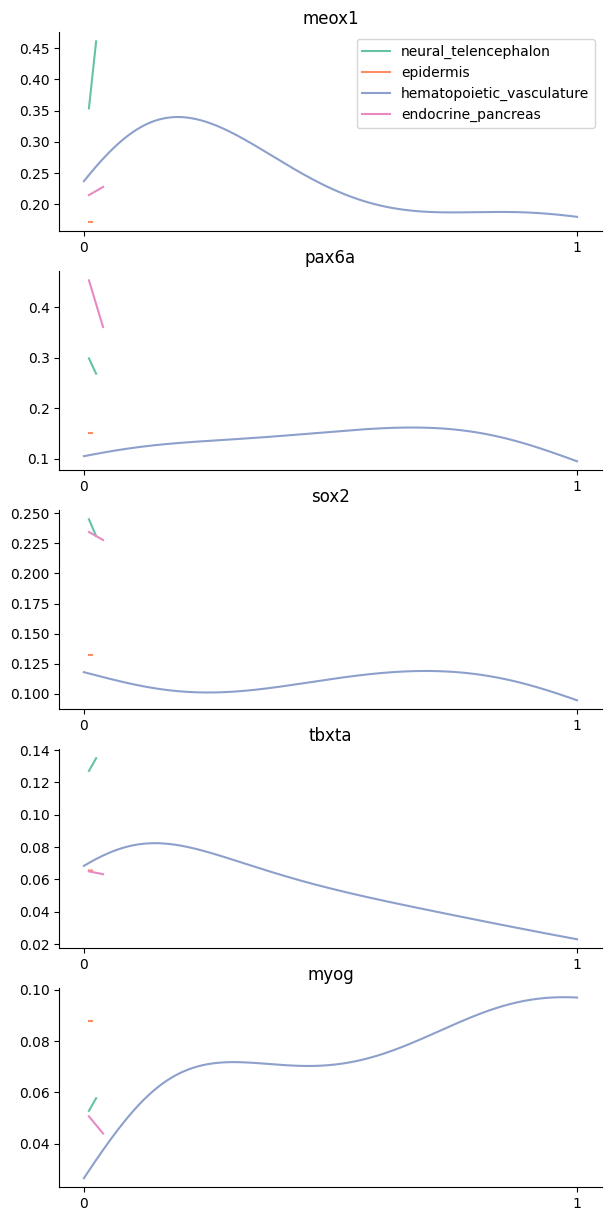

In [75]:
genes = ["meox1","pax6a","sox2","tbxta","myog"]
palantir.plot.plot_gene_trends(adata, genes)
plt.show()

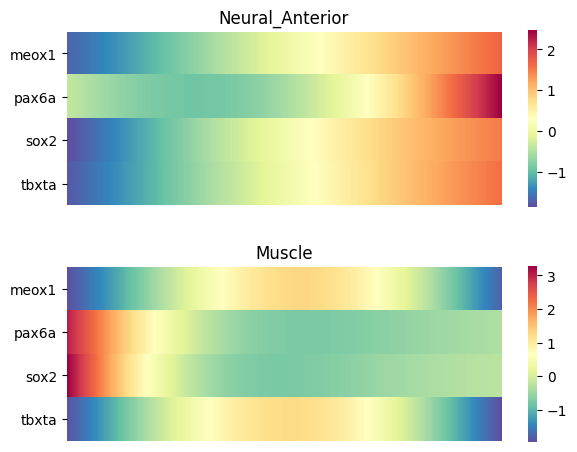

In [198]:
palantir.plot.plot_gene_trend_heatmaps(nmps, genes)
plt.show()

In [76]:
more_genes = adata.var_names[:1000]
communities = palantir.presults.cluster_gene_trends(adata, "hematopoietic_vasculature", more_genes)

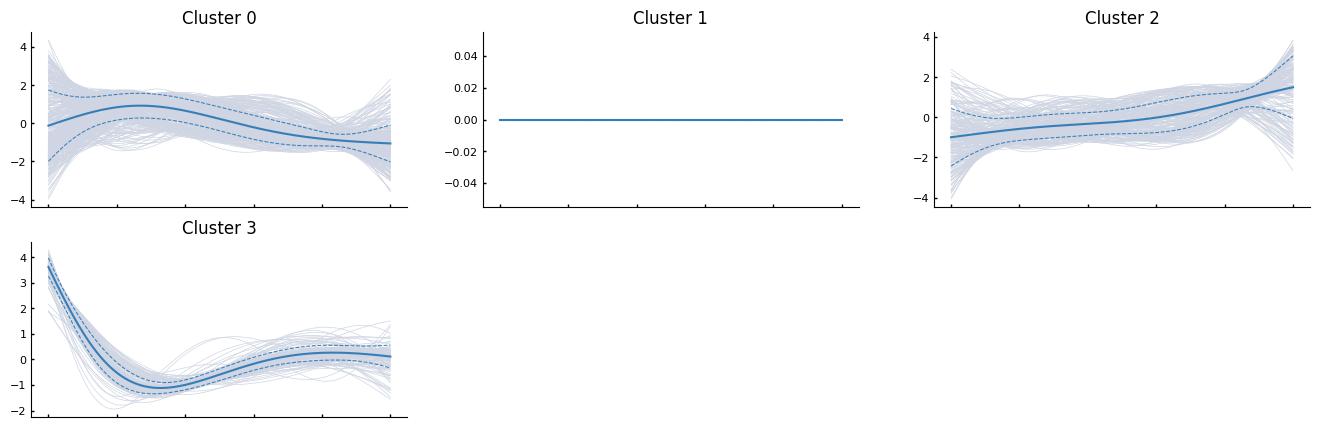

In [77]:
palantir.plot.plot_gene_trend_clusters(adata, "hematopoietic_vasculature")
plt.show()

In [81]:
communities[communities=="0"]

phtf2               0
lrp6                0
dusp16              0
crebl2              0
gpr19               0
                   ..
zgc:174698.1        0
CR847906.1          0
si:dkeyp-4c4.2      0
zgc:174653          0
si:dkey-176f19.4    0
Length: 368, dtype: category
Categories (4, object): ['0', '1', '2', '3']

## Conclusion (5/31/2024)


- Palantir pseudotime doesn't seem to capture the (real) cell differentiation trajectories - at least known from the Zebrahub (RNA velocity).

- Future directions:
    - Try other pseudotime methods (Slingshot)
    - Try RNA velocity (either RNA velocity or MultiVelo)